In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import numpy as np

<font color = 'blue'>**CNN Model with Dropout Layer**

In [ ]:
class LeNetWithDropout(nn.Module):
    def __init__(self, num_classes=10, dropout = 0.5):
        super(LeNetWithDropout, self).__init__()
        self.net = nn.Sequential(
            nn.LazyConv2d(6, kernel_size=5, padding=2), nn.Sigmoid(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.LazyConv2d(16, kernel_size=5), nn.Sigmoid(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.LazyLinear(120), nn.Sigmoid(),
            nn.Dropout(dropout),
            nn.LazyLinear(84), nn.Sigmoid(),
            nn.LazyLinear(num_classes))

        self.dropout_rate = dropout


    def forward(self, x):
        return self.net(x)

<font color = 'blue'>**Training Function**

In [2]:

def train_model(model, train_loader, loss_fn, optimizer, device):
    model.train()
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
    return

<font color = 'blue'>**Evaluation Function**

In [3]:

def evaluate_model(model, dataloader, device):
    model.eval()
    correct_predictions = 0
    total_samples = 0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predictions = torch.max(outputs, 1)
            correct_predictions += (predictions == labels).sum().item()
            total_samples += labels.size(0)

    accuracy = correct_predictions / total_samples

    return accuracy

<font color = 'blue'>**Experiment function**

In [ ]:

def run_experiment(hparams, epochs, loss_fn, device, k):
    batch_size = 256
    k = k
    # Load dataset
    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
    mnist_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
    validation_size = int(0.1 * len(mnist_dataset))  # 10% of the training set
    mnist_train, mnist_val = random_split(mnist_dataset, [len(mnist_dataset) - validation_size, validation_size])
    train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(mnist_val, batch_size=batch_size, shuffle=False)
    mnist_test = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)
    test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=False)


    # Original model
    original_model = LeNetWithDropout(**hparams).to(device)
    original_optimizer = torch.optim.Adam(original_model.parameters())

    # Training loop
    for epoch in range(epochs):
        train_model(original_model, train_loader, loss_fn, original_optimizer, device)

    # Evaluate the original model
    train_accuracy_original = evaluate_model(original_model, train_loader, device)
    #val_accuracy_original = evaluate_model(original_model, val_loader, device)
    test_accuracy_original = evaluate_model(original_model, test_loader, device)

    print("Train accuracy for original model is:", train_accuracy_original)
    # print("Validation accuracy for original model is:", val_accuracy_original)
    print("Test accuracy for original model is:", test_accuracy_original)

    # K dropout models
    best_model = LeNetWithDropout(**hparams).to(device)
    best_accuracy = 0

    for epoch in range(epochs):
        models_and_performance = []

        for model_idx in range(k):
            current_model = LeNetWithDropout(**hparams).to(device)
            current_model.load_state_dict(best_model.state_dict())
            current_model.train()
            current_model.dropout_rate = torch.rand(1).item()

            optimizer = torch.optim.Adam(current_model.parameters())

            train_model(current_model, train_loader, loss_fn, optimizer, device)

            accuracy = evaluate_model(current_model, val_loader, device)

            models_and_performance.append((current_model, accuracy))

        best_model, best_accuracy = max(models_and_performance, key=lambda x: x[1])

       # print(f'Epoch {epoch + 1}/{epochs}, Best Model Validation Accuracy: {best_accuracy}, Dropout Rate: {best_model.dropout_rate}')

    train_accuracy = evaluate_model(best_model, train_loader, device)
    print(f"Train accuracy for {k} dropout mask model is:", train_accuracy)

    # Test the final model on the test set
    test_accuracy = evaluate_model(best_model, test_loader, device)
    print(f"Test accuracy for {k} dropout mask model is:", test_accuracy)

    train_accuracy_improvement = train_accuracy - train_accuracy_original
    test_accuracy_improvement = test_accuracy - test_accuracy_original

    return train_accuracy_improvement, test_accuracy_improvement

<font color = 'blue'>**Multi-Experiment Analysis: CNN Model with Dropout on FashionMNIST**

**K=5**

In [ ]:

hparams = {'num_classes': 10, 'dropout': 0.5}
epochs = 10
device = 'cuda' if torch.cuda.is_available() else 'cpu'
loss_fn = nn.CrossEntropyLoss()

# Run multiple experiments and calculate margins of error
num_experiments = 20
train_accuracies = []
test_accuracies = []

for experiment in range(num_experiments):
    print('\n' f"Running Experiment {experiment + 1}/{num_experiments}")

    train_accuracy_improvements, test_accuracy_improvements = run_experiment(hparams, epochs, loss_fn, device, 5)
    train_accuracies.append(train_accuracy_improvements)
    test_accuracies.append(test_accuracy_improvements)

train_improvement_mean = np.mean(train_accuracies)
train_improvement_std_dev = np.std(train_accuracies)
train_improvement_margin_of_error = 1.96 * (train_improvement_std_dev / np.sqrt(num_experiments))

test_improvement_mean = np.mean(test_accuracies)
test_improvement_std_dev = np.std(test_accuracies)
test_improvement_margin_of_error = 1.96 * (test_improvement_std_dev / np.sqrt(num_experiments))

print("\nAccuracy Improvement Statistics:")
print(f"Train Improvement: Mean={train_improvement_mean}, Std Dev={train_improvement_std_dev}, Margin of Error={train_improvement_margin_of_error}")
print(f"Test Improvement: Mean={test_improvement_mean}, Std Dev={test_improvement_std_dev}, Margin of Error={test_improvement_margin_of_error}")



Running Experiment 1/20


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Train accuracy for original model is: 0.8012592592592592
Test accuracy for original model is: 0.7882
Train accuracy for 5 dropout mask model is: 0.8009259259259259
Test accuracy for 5 dropout mask model is: 0.7895

Running Experiment 2/20
Train accuracy for original model is: 0.7963888888888889
Test accuracy for original model is: 0.7862
Train accuracy for 5 dropout mask model is: 0.8014259259259259
Test accuracy for 5 dropout mask model is: 0.7877

Running Experiment 3/20
Train accuracy for original model is: 0.793037037037037
Test accuracy for original model is: 0.7826
Train accuracy for 5 dropout mask model is: 0.8012777777777778
Test accuracy for 5 dropout mask model is: 0.7885

Running Experiment 4/20
Train accuracy for original model is: 0.7938518518518518
Test accuracy for original model is: 0.7819
Train accuracy for 5 dropout mask model is: 0.8034074074074075
Test accuracy for 5 dropout mask model is: 0.7897

Running Experiment 5/20
Train accuracy for original model is: 0.79562

In [ ]:
print ("Train accuracies improvement", train_accuracies)
print ("Test accuracies improvement",test_accuracies)


Train accuracies improvement [-0.0003333333333332966, 0.005037037037036951, 0.00824074074074077, 0.00955555555555565, 0.002074074074074117, 0.003277777777777824, -0.014796296296296307, -0.0017962962962962958, 0.01142592592592584, -0.0053888888888888875, 0.0027407407407407103, 0.00622222222222224, -0.012240740740740774, -0.012944444444444425, -0.01142592592592595, 0.0006111111111111178, 0.012944444444444425, -0.0034259259259259434, 0.008203703703703713, -0.016018518518518543]
Test accuracies improvement [0.0012999999999999678, 0.0014999999999999458, 0.005900000000000016, 0.007799999999999918, -0.00019999999999997797, 0.006000000000000005, -0.011300000000000088, -0.0034999999999999476, 0.009299999999999975, -0.0040000000000000036, -0.0004999999999999449, 0.007600000000000051, -0.012299999999999978, -0.011800000000000033, -0.00770000000000004, 0.0013999999999999568, 0.009700000000000042, -0.0040000000000000036, 0.005400000000000071, -0.01760000000000006]


<font color = 'blue'>**Box plots for train and test improvements**

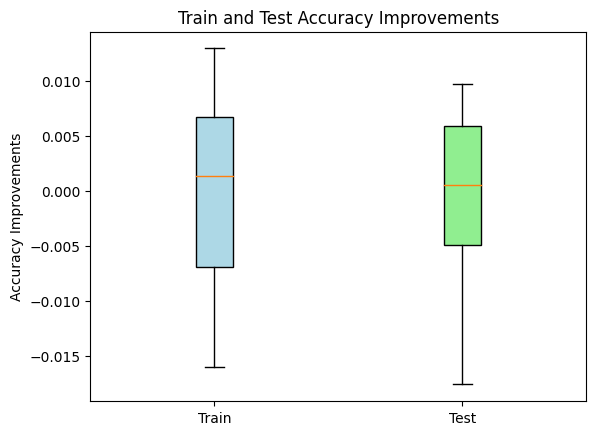

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

train_box = ax.boxplot(train_accuracies, positions=[1], patch_artist=True)
test_box = ax.boxplot(test_accuracies, positions=[2], patch_artist=True)

ax.set_xticks([1, 2])
ax.set_xticklabels(['Train', 'Test'])
ax.set_ylabel('Accuracy Improvements')
ax.set_title('Train and Test Accuracy Improvements')

colors = ['lightblue', 'lightgreen']
for box, color in zip([train_box, test_box], colors):
    for patch in box['boxes']:
        patch.set_facecolor(color)

plt.show()

<font color = 'blue'>**Multi-Experiment Analysis: CNN Model with Dropout on FashionMNIST**

**K=10**

In [ ]:

hparams = {'num_classes': 10, 'dropout': 0.5}
epochs = 10
device = 'cuda' if torch.cuda.is_available() else 'cpu'
loss_fn = nn.CrossEntropyLoss()

# Run multiple experiments and calculate margins of error
num_experiments = 20
train_accuracies = []
test_accuracies = []

for experiment in range(num_experiments):
    print('\n' f"Running Experiment {experiment + 1}/{num_experiments}")

    train_accuracy_improvements, test_accuracy_improvements = run_experiment(hparams, epochs, loss_fn, device, 10)
    train_accuracies.append(train_accuracy_improvements)
    test_accuracies.append(test_accuracy_improvements)

train_improvement_mean = np.mean(train_accuracies)
train_improvement_std_dev = np.std(train_accuracies)
train_improvement_margin_of_error = 1.96 * (train_improvement_std_dev / np.sqrt(num_experiments))

test_improvement_mean = np.mean(test_accuracies)
test_improvement_std_dev = np.std(test_accuracies)
test_improvement_margin_of_error = 1.96 * (test_improvement_std_dev / np.sqrt(num_experiments))

print("\nAccuracy Improvement Statistics:")
print(f"Train Improvement: Mean={train_improvement_mean}, Std Dev={train_improvement_std_dev}, Margin of Error={train_improvement_margin_of_error}")
print(f"Test Improvement: Mean={test_improvement_mean}, Std Dev={test_improvement_std_dev}, Margin of Error={test_improvement_margin_of_error}")



Running Experiment 1/20


100%|██████████| 26421880/26421880 [00:02<00:00, 12549801.31it/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 211456.14it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3960205.89it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 22421886.80it/s]
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw

Train accuracy for original model is: 0.8053333333333333
Test accuracy for original model is: 0.791
Train accuracy for 10 dropout mask model is: 0.8061851851851852
Test accuracy for 10 dropout mask model is: 0.7966

Running Experiment 2/20
Train accuracy for original model is: 0.808
Test accuracy for original model is: 0.7921
Train accuracy for 10 dropout mask model is: 0.8047592592592593
Test accuracy for 10 dropout mask model is: 0.7916

Running Experiment 3/20
Train accuracy for original model is: 0.8020925925925926
Test accuracy for original model is: 0.7895
Train accuracy for 10 dropout mask model is: 0.7961296296296296
Test accuracy for 10 dropout mask model is: 0.7844

Running Experiment 4/20
Train accuracy for original model is: 0.8116851851851852
Test accuracy for original model is: 0.7985
Train accuracy for 10 dropout mask model is: 0.8206851851851852
Test accuracy for 10 dropout mask mod

In [ ]:
print ("Train accuracies improvement", train_accuracies)
print ("Test accuracies improvement",test_accuracies)


Train accuracies improvement [0.0008518518518518814, -0.0032407407407407662, -0.005962962962962948, 0.009000000000000008, -0.00794444444444442, -0.007222222222222241, -0.0154629629629629, 0.002981481481481474, -0.006629629629629652, -0.004148148148148123, -0.003277777777777713, -0.0012222222222222356, -0.009370370370370362, 0.012777777777777777, -0.0012407407407407645, 0.002685185185185124, 0.0020370370370370594, -0.0004074074074074119, -0.0052962962962963545, -0.004277777777777825]
Test accuracies improvement [0.005599999999999938, -0.000500000000000056, -0.005099999999999993, 0.009299999999999975, -0.007099999999999995, -0.0025999999999999357, -0.01540000000000008, 0.0013999999999999568, -0.005800000000000027, -0.0040999999999999925, -0.0040999999999999925, 0.00039999999999995595, -0.007900000000000018, 0.01100000000000001, -0.0008000000000000229, 0.0008000000000000229, 0.00039999999999995595, 0.0015999999999999348, -0.0045000000000000595, -0.005900000000000016]


<font color = 'blue'>**Box plots for train and test improvements**

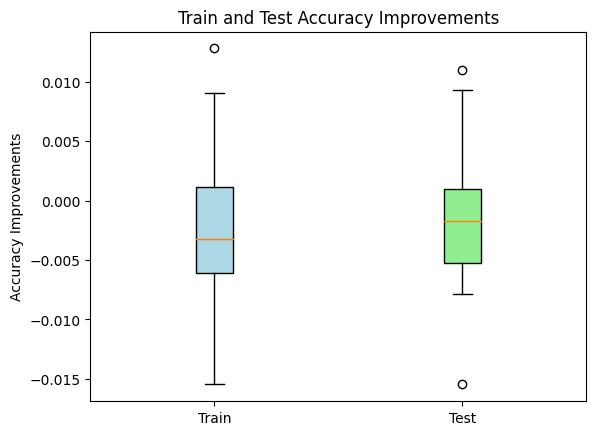

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

train_box = ax.boxplot(train_accuracies, positions=[1], patch_artist=True)
test_box = ax.boxplot(test_accuracies, positions=[2], patch_artist=True)

ax.set_xticks([1, 2])
ax.set_xticklabels(['Train', 'Test'])
ax.set_ylabel('Accuracy Improvements')
ax.set_title('Train and Test Accuracy Improvements')

colors = ['lightblue', 'lightgreen']
for box, color in zip([train_box, test_box], colors):
    for patch in box['boxes']:
        patch.set_facecolor(color)

plt.show()

<font color = 'blue'>**Multi-Experiment Analysis: CNN Model with Dropout on FashionMNIST**

**Based on minimum loss**

In [ ]:
def compute_loss(model, dataloader, loss_fn, device):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0.0
    num_batches = 0

    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)

            # Forward pass
            outputs = model(inputs)

            # Calculate the loss
            loss = loss_fn(outputs, targets)

            total_loss += loss.item()
            num_batches += 1

    average_loss = total_loss / num_batches
    return average_loss


In [ ]:

def run_experiment(hparams, epochs, loss_fn, device, k):
    batch_size = 256
    k = k
    # Load dataset
    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
    mnist_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
    validation_size = int(0.1 * len(mnist_dataset))  # 10% of the training set
    mnist_train, mnist_val = random_split(mnist_dataset, [len(mnist_dataset) - validation_size, validation_size])
    train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(mnist_val, batch_size=batch_size, shuffle=False)
    mnist_test = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)
    test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=False)


    # Original model
    original_model = LeNetWithDropout(**hparams).to(device)
    original_optimizer = torch.optim.Adam(original_model.parameters())

    # Training loop
    for epoch in range(epochs):
        train_model(original_model, train_loader, loss_fn, original_optimizer, device)

    # Evaluate the original model
    train_accuracy_original = evaluate_model(original_model, train_loader, device)
    #val_accuracy_original = evaluate_model(original_model, val_loader, device)
    test_accuracy_original = evaluate_model(original_model, test_loader, device)

    print("Train accuracy for original model is:", train_accuracy_original)
    # print("Validation accuracy for original model is:", val_accuracy_original)
    print("Test accuracy for original model is:", test_accuracy_original)

    # K dropout models
    best_model = LeNetWithDropout(**hparams).to(device)
    best_accuracy = 0

    for epoch in range(epochs):
        models_and_performance = []

        for model_idx in range(k):
            current_model = LeNetWithDropout(**hparams).to(device)
            current_model.load_state_dict(best_model.state_dict())
            current_model.train()
            current_model.dropout_rate = torch.rand(1).item()

            optimizer = torch.optim.Adam(current_model.parameters())

            train_model(current_model, train_loader, loss_fn, optimizer, device)

            val_loss = compute_loss(current_model, val_loader, loss_fn, device)

            models_and_performance.append((current_model, val_loss))

        best_model, best_loss = min(models_and_performance, key=lambda x: x[1])

       #print(f'Epoch {epoch + 1}/{epochs}, Best Model Validation Accuracy: {best_loss}, Dropout Rate: {best_model.dropout_rate}')

    train_accuracy = evaluate_model(best_model, train_loader, device)
    print(f"Train accuracy for {k} dropout mask model is:", train_accuracy)

    # Test the final model on the test set
    test_accuracy = evaluate_model(best_model, test_loader, device)
    print(f"Test accuracy for {k} dropout mask model is:", test_accuracy)

    train_accuracy_improvement = train_accuracy - train_accuracy_original
    test_accuracy_improvement = test_accuracy - test_accuracy_original

    return train_accuracy_improvement, test_accuracy_improvement

In [ ]:
hparams = {'num_classes': 10, 'dropout': 0.5}
epochs = 10
device = 'cuda' if torch.cuda.is_available() else 'cpu'
loss_fn = nn.CrossEntropyLoss()

# Run multiple experiments and calculate margins of error
num_experiments = 20
train_accuracies = []
test_accuracies = []

for experiment in range(num_experiments):
    print('\n' f"Running Experiment {experiment + 1}/{num_experiments}")

    train_accuracy_improvements, test_accuracy_improvements = run_experiment(hparams, epochs, loss_fn, device, 5)
    train_accuracies.append(train_accuracy_improvements)
    test_accuracies.append(test_accuracy_improvements)

train_improvement_mean = np.mean(train_accuracies)
train_improvement_std_dev = np.std(train_accuracies)
train_improvement_margin_of_error = 1.96 * (train_improvement_std_dev / np.sqrt(num_experiments))

test_improvement_mean = np.mean(test_accuracies)
test_improvement_std_dev = np.std(test_accuracies)
test_improvement_margin_of_error = 1.96 * (test_improvement_std_dev / np.sqrt(num_experiments))

print("\nAccuracy Improvement Statistics:")
print(f"Train Improvement: Mean={train_improvement_mean}, Std Dev={train_improvement_std_dev}, Margin of Error={train_improvement_margin_of_error}")
print(f"Test Improvement: Mean={test_improvement_mean}, Std Dev={test_improvement_std_dev}, Margin of Error={test_improvement_margin_of_error}")



Running Experiment 1/20
Train accuracy for original model is: 0.8040925925925926
Test accuracy for original model is: 0.7916
Train accuracy for 5 dropout mask model is: 0.7935740740740741
Test accuracy for 5 dropout mask model is: 0.7834

Running Experiment 2/20
Train accuracy for original model is: 0.8026851851851852
Test accuracy for original model is: 0.7925
Train accuracy for 5 dropout mask model is: 0.7978703703703703
Test accuracy for 5 dropout mask model is: 0.785

Running Experiment 3/20
Train accuracy for original model is: 0.8001296296296296
Test accuracy for original model is: 0.7882
Train accuracy for 5 dropout mask model is: 0.7917037037037037
Test accuracy for 5 dropout mask model is: 0.7807

Running Experiment 4/20
Train accuracy for original model is: 0.7991851851851852
Test accuracy for original model is: 0.7911
Train accuracy for 5 dropout mask model is: 0.8107592592592593
Test accuracy for 5 dropout mask model is: 0.7988

Running Experiment 5/20
Train accuracy for o

Train accuracies improvement [-0.010518518518518483, -0.004814814814814827, -0.008425925925925948, 0.01157407407407407, 0.004814814814814827, -0.0003148148148147678, 0.008592592592592596, -0.019037037037036963, -0.005814814814814717, 0.003074074074074118, 0.010685185185185131, -0.019425925925925958, 0.011888888888888838, -0.0023148148148147696, -0.016962962962962957, -0.006648148148148181, -0.0026481481481481772, -0.013055555555555598, -0.015000000000000013, -0.005796296296296299]
Test accuracies improvement [-0.008199999999999985, -0.007499999999999951, -0.007500000000000062, 0.007699999999999929, 0.008299999999999974, -0.0014000000000000679, 0.0026999999999999247, -0.018100000000000005, -0.0029000000000000137, 0.0032999999999999696, 0.011599999999999944, -0.017000000000000015, 0.006700000000000039, -0.0032999999999999696, -0.011199999999999988, -0.005400000000000071, -0.0030999999999999917, -0.01200000000000001, -0.012500000000000067, -0.00539999999999996]


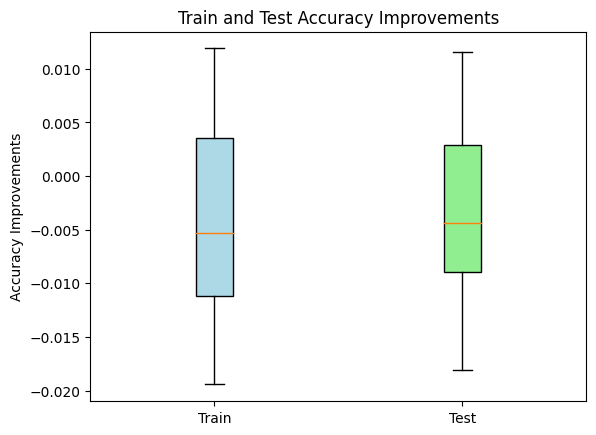

In [ ]:
print ("Train accuracies improvement", train_accuracies)
print ("Test accuracies improvement",test_accuracies)

import matplotlib.pyplot as plt

fig, ax = plt.subplots()

train_box = ax.boxplot(train_accuracies, positions=[1], patch_artist=True)
test_box = ax.boxplot(test_accuracies, positions=[2], patch_artist=True)

ax.set_xticks([1, 2])
ax.set_xticklabels(['Train', 'Test'])
ax.set_ylabel('Accuracy Improvements')
ax.set_title('Train and Test Accuracy Improvements')

colors = ['lightblue', 'lightgreen']
for box, color in zip([train_box, test_box], colors):
    for patch in box['boxes']:
        patch.set_facecolor(color)

plt.show()

<font color = 'blue'>**Multi-Experiment Analysis: CNN Model with Dropout on FashionMNIST**

**One epoch**

In [ ]:

def run_experiment(hparams, epochs, loss_fn, device, k):
    batch_size = 256
    k = k
    # Load dataset
    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
    mnist_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
    validation_size = int(0.1 * len(mnist_dataset))  # 10% of the training set
    mnist_train, mnist_val = random_split(mnist_dataset, [len(mnist_dataset) - validation_size, validation_size])
    train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(mnist_val, batch_size=batch_size, shuffle=False)
    mnist_test = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)
    test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=False)


    # Original model
    original_model = LeNetWithDropout(**hparams).to(device)
    original_optimizer = torch.optim.Adam(original_model.parameters())

    # Training loop
    for epoch in range(epochs):
        train_model(original_model, train_loader, loss_fn, original_optimizer, device)

    # Evaluate the original model
    train_accuracy_original = evaluate_model(original_model, train_loader, device)
    #val_accuracy_original = evaluate_model(original_model, val_loader, device)
    test_accuracy_original = evaluate_model(original_model, test_loader, device)

    print("Train accuracy for original model is:", train_accuracy_original)
    # print("Validation accuracy for original model is:", val_accuracy_original)
    print("Test accuracy for original model is:", test_accuracy_original)

    # K dropout models
    best_model = LeNetWithDropout(**hparams).to(device)
    best_accuracy = 0

    for epoch in range(epochs):
        models_and_performance = []

        for model_idx in range(k):
            current_model = LeNetWithDropout(**hparams).to(device)
            current_model.load_state_dict(best_model.state_dict())
            current_model.train()
            current_model.dropout_rate = torch.rand(1).item()

            optimizer = torch.optim.Adam(current_model.parameters())

            train_model(current_model, train_loader, loss_fn, optimizer, device)

            accuracy = evaluate_model(current_model, val_loader, device)

            models_and_performance.append((current_model, accuracy))

        best_model, best_accuracy = max(models_and_performance, key=lambda x: x[1])

        print(f'Epoch {epoch + 1}/{epochs}, Best Model Validation Accuracy: {best_accuracy}, Dropout Rate: {best_model.dropout_rate}')

    train_accuracy = evaluate_model(best_model, train_loader, device)
    print(f"Train accuracy for {k} dropout mask model is:", train_accuracy)

    # Test the final model on the test set
    test_accuracy = evaluate_model(best_model, test_loader, device)
    print(f"Test accuracy for {k} dropout mask model is:", test_accuracy)

    train_accuracy_improvement = train_accuracy - train_accuracy_original
    test_accuracy_improvement = test_accuracy - test_accuracy_original

    return train_accuracy_improvement, test_accuracy_improvement

In [ ]:

hparams = {'num_classes': 10, 'dropout': 0.5}
epochs = 1
device = 'cuda' if torch.cuda.is_available() else 'cpu'
loss_fn = nn.CrossEntropyLoss()

# Run multiple experiments and calculate margins of error
num_experiments = 20
train_accuracies = []
test_accuracies = []

for experiment in range(num_experiments):
    print('\n' f"Running Experiment {experiment + 1}/{num_experiments}")

    train_accuracy_improvements, test_accuracy_improvements = run_experiment(hparams, epochs, loss_fn, device, 10)
    train_accuracies.append(train_accuracy_improvements)
    test_accuracies.append(test_accuracy_improvements)

train_improvement_mean = np.mean(train_accuracies)
train_improvement_std_dev = np.std(train_accuracies)
train_improvement_margin_of_error = 1.96 * (train_improvement_std_dev / np.sqrt(num_experiments))

test_improvement_mean = np.mean(test_accuracies)
test_improvement_std_dev = np.std(test_accuracies)
test_improvement_margin_of_error = 1.96 * (test_improvement_std_dev / np.sqrt(num_experiments))

print("\nAccuracy Improvement Statistics:")
print(f"Train Improvement: Mean={train_improvement_mean}, Std Dev={train_improvement_std_dev}, Margin of Error={train_improvement_margin_of_error}")
print(f"Test Improvement: Mean={test_improvement_mean}, Std Dev={test_improvement_std_dev}, Margin of Error={test_improvement_margin_of_error}")


Running Experiment 1/20


100%|██████████| 26421880/26421880 [00:02<00:00, 12467913.36it/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 210928.67it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3883023.04it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 5624453.50it/s]
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw

Train accuracy for original model is: 0.5892592592592593
Test accuracy for original model is: 0.591
Epoch 1/1, Best Model Validation Accuracy: 0.5961666666666666, Dropout Rate: 0.3078286647796631
Train accuracy for 10 dropout mask model is: 0.6054814814814815
Test accuracy for 10 dropout mask model is: 0.6023

Running Experiment 2/20
Train accuracy for original model is: 0.5813148148148148
Test accuracy for original model is: 0.5815
Epoch 1/1, Best Model Validation Accuracy: 0.6053333333333333, Dropout Rate: 0.29581671953201294
Train accuracy for 10 dropout mask model is: 0.6081666666666666
Test accuracy for 10 dropout mask model is: 0.6054

Running Experiment 3/20
Train accuracy for original model is: 0.5876666666666667
Test accuracy for original model is: 0.5906
Epoch 1/1, Best Model Validation Accuracy: 0.6126666666666667, Dropout Rate: 0.874519407749176
Train accuracy for 10 dropout mask model 

Train accuracies improvement [0.01622222222222225, 0.026851851851851793, 0.012222222222222245, 0.020277777777777728, 0.017000000000000015, 0.00020370370370370594, 0.015148148148148133, 0.01953703703703702, 0.02255555555555555, 0.019000000000000017, 0.010648148148148184, 0.026537037037037026, 0.02514814814814814, 0.036666666666666736, 0.02792592592592591, 0.026518518518518497, 0.039851851851851805, 0.01172222222222219, 0.010314814814814777, -0.0019259259259259975]
Test accuracies improvement [0.011299999999999977, 0.023900000000000032, 0.011199999999999988, 0.01970000000000005, 0.02190000000000003, 0.006300000000000083, 0.01090000000000002, 0.020099999999999896, 0.0252, 0.01419999999999999, 0.01100000000000001, 0.029100000000000015, 0.020199999999999996, 0.02970000000000006, 0.021399999999999975, 0.02750000000000008, 0.04590000000000005, 0.01539999999999997, 0.005199999999999982, -0.0047000000000000375]


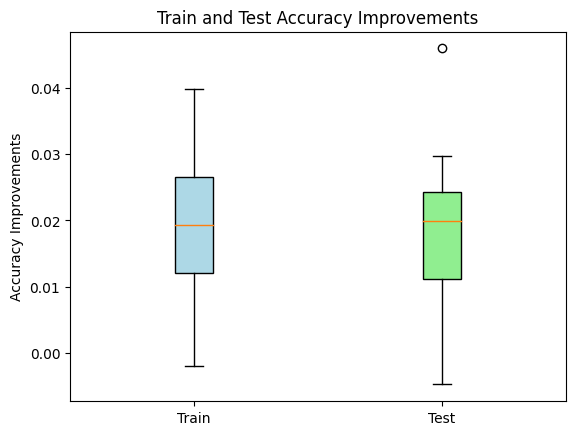

In [ ]:
print ("Train accuracies improvement", train_accuracies)
print ("Test accuracies improvement",test_accuracies)

import matplotlib.pyplot as plt

fig, ax = plt.subplots()

train_box = ax.boxplot(train_accuracies, positions=[1], patch_artist=True)
test_box = ax.boxplot(test_accuracies, positions=[2], patch_artist=True)

ax.set_xticks([1, 2])
ax.set_xticklabels(['Train', 'Test'])
ax.set_ylabel('Accuracy Improvements')
ax.set_title('Train and Test Accuracy Improvements')

colors = ['lightblue', 'lightgreen']
for box, color in zip([train_box, test_box], colors):
    for patch in box['boxes']:
        patch.set_facecolor(color)

plt.show()

In [8]:
class LeNet(nn.Module):
    def __init__(self, num_classes=10):
        super(LeNet, self).__init__()
        self.net = nn.Sequential(
            nn.LazyConv2d(6, kernel_size=5, padding=2), nn.Sigmoid(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.LazyConv2d(16, kernel_size=5), nn.Sigmoid(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.LazyLinear(120), nn.Sigmoid(),
            nn.LazyLinear(84), nn.Sigmoid(),
            nn.LazyLinear(num_classes))

    def forward(self, x):
        return self.net(x)

In [9]:
batch_size = 256

# Load dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
mnist_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
validation_size = int(0.1 * len(mnist_dataset))  # 10% of the training set
mnist_train, mnist_val = random_split(mnist_dataset, [len(mnist_dataset) - validation_size, validation_size])
train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(mnist_val, batch_size=batch_size, shuffle=False)
mnist_test = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)
test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=False)

hparams = {'num_classes': 10}
epochs = 10
device = 'cuda' if torch.cuda.is_available() else 'cpu'
loss_fn = nn.CrossEntropyLoss()

model1 = LeNet(**hparams).to(device)
optimizer1 = torch.optim.Adam(model1.parameters())

# Training loop
for epoch in range(epochs):
     train_model(model1, train_loader, loss_fn, optimizer1, device)

train_accuracy1 = evaluate_model(model1, train_loader, device)
test_accuracy1 = evaluate_model(model1, test_loader, device)

print("Train accuracy for model without dropout is:", train_accuracy1)
print("Test accuracy for model without dropout is:", test_accuracy1)


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Train accuracy for model without dropout is: 0.8182037037037037
Test accuracy for model without dropout is: 0.8013
